In [14]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np

import scipy as scp
import sklearn
import sys, os, pickle
import csv
sys.path.append(os.path.join('..'))


from numpy import genfromtxt
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
###lafter config
def load_laftr(DATANAME):
    import glob2
    data_dict = {'german': 'WeightedDemParWassGan--model_fair_coeff-3_0', 'bank': 'WeightedDemParWassGan--model_fair_coeff-0_3', \
                'meps': 'WeightedDemParWassGan--model_fair_coeff-0_7', 'compas': 'WeightedEqoppWassGan--model_fair_coeff-0_5',\
                'adult': 'WeightedDemParWassGan--model_fair_coeff-0_1', 'celeba_res50' : 'WeightedEqoppWassGan--model_fair_coeff-0_5'}
#     for data_name in ['compas', 'german', 'meps', 'bank', 'adult']:
#         print(data_name, len(glob2.glob('../../git/laftr/experiments/full_sweep_{}/*{}*/test_metrics.csv'.format(data_name, data_dict[data_name]))))

    for data_name in [DATANAME]:

        all_header_files = glob2.glob('/home/taeuk/network/git/fair_classification/laftr/experiments/full_sweep_{}/*{}*/test_metrics.csv'.format(data_name, data_dict[data_name]))
        all_header_files

        lst1 = []
        lst2 = []
        for i in range(len(all_header_files)):
            file = open(all_header_files[i])
            name = all_header_files[i].split('class-')[1].split('/')[0]
            met_dic = {'name':name}
            for line in file:
                fields = line.split(",")
                if fields[0] in ['A=?_TPR', 'A=?_TNR', 'A=?_FPR', 'A=?_FNR',\
                                'A=1_TPR', 'A=1_TNR', 'A=1_FPR', 'A=1_FNR',\
                                'A=0_TPR', 'A=0_TNR', 'A=0_FPR', 'A=0_FNR',\
                                'A=0_PredPR', 'A=1_PredPR']:
                    fields[1] = fields[1].split("\n")[0]
                    met_dic[fields[0]] = float(fields[1])
                if fields[0] in ['ErrY']:
                    fields[1] = fields[1].split("\n")[0]
                    met_dic['ACC'] = 1-float(fields[1])

            try:
                met_dic['Eq_Opp_diff'] = float("{:.3f}".format(abs(met_dic['A=1_TPR'] - met_dic['A=0_TPR'])))
                met_dic['Av_abs_odd_diff'] = float("{:.3f}".format(0.5 * (abs(met_dic['A=1_TPR'] - met_dic['A=0_TPR']) + \
                                                                  abs(met_dic['A=1_FPR'] - met_dic['A=0_FPR']))))
                met_dic['abs_DP'] = abs(1 - met_dic['A=0_PredPR']/met_dic['A=1_PredPR'])
                met_dic['Bal_Acc'] = 0.5 * (met_dic['A=?_TPR'] + 1 - met_dic['A=?_FPR'])
                met_dic['Bal_Acc_diff'] = 0.5 * abs((met_dic['A=1_TPR'] + 1 - met_dic['A=1_FPR']) - (met_dic['A=0_TPR'] + 1 - met_dic['A=0_FPR']))
            except:
                pass


            lst1.append(met_dic)

        total = {}

        for i in range(len(lst1)):
            met_dic = {}
            for metric in ['name', 'Bal_Acc', 'Eq_Opp_diff', 'Av_abs_odd_diff', 'abs_DP', 'A=?_TPR', 'Bal_Acc_diff']:
                if metric in lst1[i]:
                    met_dic[metric] = lst1[i][metric]
            lst2.append(met_dic)

        for metric in ['ACC', 'Eq_Opp_diff', 'Av_abs_odd_diff', 'abs_DP', 'A=?_TPR']:
            total[metric]= np.mean([i[metric] for i in lst1 if metric in i])


    #     ###save data###
    #     for metric in ['Bal_Acc', 'Eq_Opp_diff', 'Av_abs_odd_diff', 'Bal_Acc_diff']:
    #         data = np.array([_dict[metric] for _dict in lst1 if metric in _dict])
    #         print(metric, data)
    #         np.save('result/{}/laftr_{}.npy'.format(data_name, metric), data)

    EqOpp = np.array([abs(lst1[i]['A=1_TPR']-lst1[i]['A=0_TPR']) for i in range(len(lst1))])
    PP = np.array([abs(lst1[i]['A=1_FPR']-lst1[i]['A=0_FPR']) for i in range(len(lst1))])
    EqOdd = EqOpp + PP
    
    ACC = np.array([lst1[i]['ACC'] for i in range(len(lst1))])
    LAFTR = [ EqOdd, ACC]
    
    return LAFTR


In [11]:
DATANAME = 'adult'
total_tpr = np.load('/home/taeuk/network/AIF360/examples/result_data_t2/{}/total_tpr.npy'.format(DATANAME))
total_tpr_priv = np.load('/home/taeuk/network/AIF360/examples/result_data_t2/{}/total_tpr_priv.npy'.format(DATANAME))
total_tpr_unpriv = np.load('/home/taeuk/network/AIF360/examples/result_data_t2/{}/total_tpr_unpriv.npy'.format(DATANAME))
total_eqopp_diff = np.load('/home/taeuk/network/AIF360/examples/result_data_t2/{}/total_eqopp_diff.npy'.format(DATANAME))

total_fpr = np.load('/home/taeuk/network/AIF360/examples/result_data_t2/{}/total_fpr.npy'.format(DATANAME))
total_fpr_priv = np.load('/home/taeuk/network/AIF360/examples/result_data_t2/{}/total_fpr_priv.npy'.format(DATANAME))
total_fpr_unpriv = np.load('/home/taeuk/network/AIF360/examples/result_data_t2/{}/total_fpr_unpriv.npy'.format(DATANAME))
total_fpr_diff = np.load('/home/taeuk/network/AIF360/examples/result_data_t2/{}/total_fpr_diff.npy'.format(DATANAME))

total_acc = np.load('/home/taeuk/network/AIF360/examples/result_data_t2/{}/total_acc.npy'.format(DATANAME))
total_acc_priv = np.load('/home/taeuk/network/AIF360/examples/result_data_t2/{}/total_acc_priv.npy'.format(DATANAME))
total_acc_unpriv = np.load('/home/taeuk/network/AIF360/examples/result_data_t2/{}/total_acc_unpriv.npy'.format(DATANAME))
# abs(total_acc_unpriv - total_acc_priv) = np.load('/home/taeuk/network/AIF360/examples/result_data_t2/{}/total_acc_diff.npy'.format(DATANAME))

total_balanced_acc = np.load('/home/taeuk/network/AIF360/examples/result_data_t2/{}/total_balanced_acc.npy'.format(DATANAME))
total_disimpact = np.load('/home/taeuk/network/AIF360/examples/result_data_t2/{}/total_disimpact.npy'.format(DATANAME))
total_theil_idx = np.load('/home/taeuk/network/AIF360/examples/result_data_t2/{}/total_theil_idx.npy'.format(DATANAME))
stat_parity_diff = np.load('/home/taeuk/network/AIF360/examples/result_data_t2/{}/stat_parity_diff.npy'.format(DATANAME))



total_tpr[5] = np.load('/home/taeuk/network/AIF360/examples/result_data/{}/total_tpr.npy'.format(DATANAME))[5]
total_tpr_priv[5] = np.load('/home/taeuk/network/AIF360/examples/result_data/{}/total_tpr_priv.npy'.format(DATANAME))[5]
total_tpr_unpriv[5] = np.load('/home/taeuk/network/AIF360/examples/result_data/{}/total_tpr_unpriv.npy'.format(DATANAME))[5]
total_eqopp_diff[5] = np.load('/home/taeuk/network/AIF360/examples/result_data/{}/total_eqopp_diff.npy'.format(DATANAME))[5]

total_fpr[5] = np.load('/home/taeuk/network/AIF360/examples/result_data/{}/total_fpr.npy'.format(DATANAME))[5]
total_fpr_priv[5] = np.load('/home/taeuk/network/AIF360/examples/result_data/{}/total_fpr_priv.npy'.format(DATANAME))[5]
total_fpr_unpriv[5] = np.load('/home/taeuk/network/AIF360/examples/result_data/{}/total_fpr_unpriv.npy'.format(DATANAME))[5]
total_fpr_diff[5] = np.load('/home/taeuk/network/AIF360/examples/result_data/{}/total_fpr_diff.npy'.format(DATANAME))[5]

total_acc[5] = np.load('/home/taeuk/network/AIF360/examples/result_data/{}/total_acc.npy'.format(DATANAME))[5]
total_acc_priv[5] = np.load('/home/taeuk/network/AIF360/examples/result_data/{}/total_acc_priv.npy'.format(DATANAME))[5]
total_acc_unpriv[5] = np.load('/home/taeuk/network/AIF360/examples/result_data/{}/total_acc_unpriv.npy'.format(DATANAME))[5]
# abs(total_acc_unpriv - total_acc_priv)[5] = np.load('/home/taeuk/network/AIF360/examples/result_data/{}/total_acc_diff.npy'.format(DATANAME))

total_balanced_acc[5] = np.load('/home/taeuk/network/AIF360/examples/result_data/{}/total_balanced_acc.npy'.format(DATANAME))[5]
total_disimpact[5] = np.load('/home/taeuk/network/AIF360/examples/result_data/{}/total_disimpact.npy'.format(DATANAME))[5]
total_theil_idx[5] = np.load('/home/taeuk/network/AIF360/examples/result_data/{}/total_theil_idx.npy'.format(DATANAME))[5]
stat_parity_diff[5] = np.load('/home/taeuk/network/AIF360/examples/result_data/{}/stat_parity_diff.npy'.format(DATANAME))[5]



In [12]:
total_aveodds_diff = 0.5 * (abs(total_tpr_priv - total_tpr_unpriv) + abs(total_fpr_priv - total_fpr_unpriv))
bal_acc_diff = 0.5 * abs((total_tpr_priv - total_fpr_priv) -(total_tpr_unpriv - total_fpr_unpriv))
bal_acc_overall = 0.5 * (total_tpr + 1 - total_fpr)

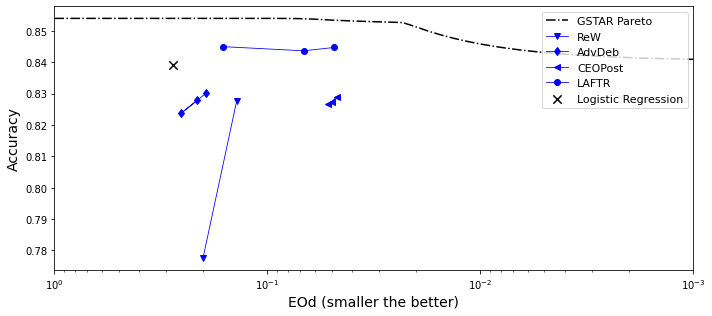

In [27]:
f, axs = plt.subplots(figsize=(10,4.5))

if DATANAME == 'compas':
        gstar_ms = pickle.load(open('./results/{}/GSTAR_MS_8.pkl'.format(DATANAME), 'rb'))
        axs.semilogx(gstar_ms[0], gstar_ms[1], 'k-.', label='GSTAR Pareto')
else:
    gstar_ms = pickle.load(open('./results/{}/GSTAR_MS.pkl'.format(DATANAME), 'rb'))

    if DATANAME == 'adult':
        pm = gstar_ms[1][0] - pp[1][0]
        axs.semilogx(gstar_ms[0], [i -pm for i in gstar_ms[1]], 'k-.', label='GSTAR Pareto')
    else:
        axs.semilogx(gstar_ms[0], gstar_ms[1], 'k-.', label='GSTAR Pareto')
            
original = pickle.load(open('./results/{}/base_dict.pkl'.format(DATANAME, DATANAME), 'rb'))
axs.scatter(original['eqodd'], original['acc'], label='Logistic Regression', color='k', marker='x', s=70)


axs.plot(total_aveodds_diff[6][[2, 1]], total_acc[6][[2, 1]], label='ReW', color='b', \
         marker='v', lw = 0.8, ms = 6, zorder = 2)

eqodd_results = []

calib_eqodd_results_weighted = []
for i in range(5):
    with open('./results/{}/{}_eqodd_result_trial{}.csv'.format(DATANAME, DATANAME, i)) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        lst = []
        cnt = 0
        for row in readCSV:
            lst.append((row))
            cnt += 1
            if cnt > 1:
                break
        calib_eqodd_results_weighted.append(np.array(lst).reshape(-1,2).astype(float))


with open("./results/{}_multi_const_result.pkl".format(DATANAME), 'rb') as f:
     eval_dict = pickle.load(f)
            
if DATANAME == 'german':
    axs.plot(np.array(eval_dict['AdvDeb'][0])[[0, 2, 3]], np.array(eval_dict['AdvDeb'][2])[[0, 2, 3]], label='AdvDeb', color='b', \
             marker='d', lw = 0.8, ms = 6, zorder = 2)
    
else:
    axs.plot(np.array(eval_dict['AdvDeb'][0])[[0, 1, 3]], np.array(eval_dict['AdvDeb'][2])[[0, 1, 3]], label='AdvDeb', color='b', \
                 marker='d', lw = 0.8, ms = 6, zorder = 2)

calib_eqodd_points_after_x = [e[1][0] for e in calib_eqodd_results_weighted]
calib_eqodd_points_after_y = [e[1][1] for e in calib_eqodd_results_weighted]

axs.plot(calib_eqodd_points_after_x[:3], calib_eqodd_points_after_y[:3], \
         label='CEOPost', c='b', marker='<', lw = 0.8, ms = 6, zorder = 2)

LAFTR = load_laftr(DATANAME)
if DATANAME == 'german':
    axs.plot(LAFTR[0][0:5], LAFTR[1][0:5], label='LAFTR', color='b', marker='o', lw = 0.8, ms = 6, zorder = 2)
else:
    axs.plot(LAFTR[0][[0,2,4]], LAFTR[1][[0,2,4]], label='LAFTR', color='b', marker='o', lw = 0.8, ms = 6, zorder = 2)

if DATANAME == 'compas':
    axs.set_ylim(0.5, 0.8)

axs.set_xlim(1e-3, 1)
# axs.set_ylim(0.55, .75)
axs.invert_xaxis()
#     axs.set_xscale('symlog')


# axs.set_xlim(1e-6)
# # axs.set_ylim(1, 0)
# axs.invert_xaxis()

axs.set_ylabel('Accuracy', fontsize=14)
axs.set_xlabel('EOd (smaller the better)', fontsize=14)

# axs.set_aspect('equal', 'box')
# plt.legend(bbox_to_anchor=(1.00, 1.00), frameon=False)
plt.legend(loc='upper right',frameon=True, fontsize = 11)
# axs.legend(loc='bottom right', frameon=False)
plt.tight_layout()




# plt.savefig('./figures/{}/fsns_{}_AAAI22.pdf'.format(DATANAME, DATANAME), dpi=300)
